<a href="https://colab.research.google.com/github/andyrids/mipo_trajectory/blob/main/MiPo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import haversine
    import folium
except ImportError:
    %pip install haversine mapclassify folium -q
    import haversine
    import folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.1 MB/s eta 0:00:00


In [2]:
import io
import multiprocessing
import pathlib
import zipfile
from collections import defaultdict
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import requests
from numpy import float64
from numpy.typing import ArrayLike, NDArray
from pandas import DataFrame, Series, concat, read_csv, to_datetime, to_timedelta
from scipy.stats import median_abs_deviation
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
# from sklearn.metrics import silhouette_score

In [4]:
def calculate_earth_radius(latitude_values: ArrayLike) -> NDArray[float64]:
    """"""
    EQUATORIAL_RADIUS = 6_378_137
    POLAR_RADIUS = 6_356_752

    latitude_rad = np.radians(latitude_values)
    numerator = (
        (EQUATORIAL_RADIUS**2 * np.cos(latitude_rad))**2 +
        (POLAR_RADIUS**2 * np.sin(latitude_rad))**2
    )
    denominator = (
        (EQUATORIAL_RADIUS * np.cos(latitude_rad))**2 +
        (POLAR_RADIUS * np.sin(latitude_rad))**2
    )
    earth_radius = np.sqrt(numerator / denominator)
    return earth_radius


def latlong_to_cartesian_xyz(latitude_values: ArrayLike, longitude_values: ArrayLike) -> Tuple[NDArray[float64], NDArray[float64], NDArray[float64]]:
    """"""
    latitude_rad = np.radians(latitude_values)
    longitude_rad = np.radians(longitude_values)
    earth_radius = calculate_earth_radius(latitude_values)

    x = earth_radius * np.cos(latitude_rad) * np.cos(longitude_rad)
    y = earth_radius * np.cos(latitude_rad) * np.sin(longitude_rad)
    z = earth_radius * np.sin(latitude_rad)
    return x, y, z


def calculate_mzx(data: ArrayLike, c_mad: float = 1.4826) -> NDArray[float64]:
    """"""
    data = np.where(np.isinf(data), np.nan, data)
    if np.isnan(data).all():
        return data
    median_ad = median_abs_deviation(data, nan_policy="omit")
    constant = c_mad

    if not median_ad or np.isnan(median_ad):
        mean_ad = np.nanmean(np.abs(data - np.nanmean(data)))
        if not mean_ad or np.isnan(mean_ad):
            return np.full_like(data, np.nan)

        modified_zscore = constant * (data - np.nanmedian(data)) / mean_ad
    else:
        modified_zscore = constant * (data - np.nanmedian(data)) / median_ad
    return np.abs(modified_zscore)

In [5]:
def read_csv_files(path: pathlib.Path) -> DataFrame:
    data = read_csv(path, sep=";")
    return data.assign(uid=path.stem)


def process_file(path: pathlib.Path) -> DataFrame | None:
    try:
        return read_csv_files(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


num_processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=num_processes) as pool:
    data_path = pathlib.Path("data/data")
    if not data_path.exists():
        r = requests.get("https://figshare.com/ndownloader/files/16442771")
        zf = zipfile.ZipFile(io.BytesIO(r.content))
        zf.extractall(path="data")

    paths = tuple(data_path.glob("*.txt"))
    results = pool.map(process_file, paths[:100])

dataframes = filter(lambda x: isinstance(x, DataFrame), results)

data = (
    concat(dataframes)
    .assign(t=lambda x: to_timedelta(x["t"], unit="s"))
    .assign(datetime=lambda x: to_datetime("now") + x["t"])
    .filter(("uid", "datetime", "x", "y", ), axis="columns")
    .rename(columns={"x": "longitude", "y": "latitude"})
    .astype({"uid": "string"})
    .sort_values(["uid", "datetime"])
    .reset_index(drop=True)
)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40074 entries, 0 to 40073
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   uid        40074 non-null  string        
 1   datetime   40074 non-null  datetime64[ns]
 2   longitude  40074 non-null  float64       
 3   latitude   40074 non-null  float64       
dtypes: datetime64[ns](1), float64(2), string(1)
memory usage: 1.2 MB


In [7]:
# kmeans = KMeans(n_clusters=2, random_state=0).fit(X[[0,-1]])
# res = kmeans.cluster_centers_

In [ ]:
def position_of_line(
        point_a: NDArray[float64],
        point_b: NDArray[float64],
        point_c: NDArray[float64]
    ) -> int:
    """Determine which side of a line point point_c lies on."""

    # X,Y points
    if point_a.size == point_b.size == point_c.size == 2:
        # Extract x,y coordinates from the points
        point_a_x, point_a_y = point_a  # point A coordinates
        point_b_x, point_b_y = point_b  # point B coordinates
        point_c_x, point_c_y = point_c  # point C coordinates

        # calculate the sign of the cross product
        # indicates if C is on the left (+1) or right (-1) of line AB
        position = np.sign(
            (point_b_x - point_a_x) *
            (point_c_y - point_a_y) -
            (point_b_y - point_a_y) *
            (point_c_x - point_a_x)
        )
    # X,Y,Z points
    else:
        # 3D points use the cross product of vectors
        vector_ab = point_b - point_a  # vector from A to B
        vector_ac = point_c - point_a  # vector from A to C

        # calculate cross product
        cross_product = np.cross(vector_ab, vector_ac)

        # Y-component of idicates above (+) or below (-)
        position = np.sign(cross_product[1])

    return 1 if position >= 0 else -1

In [23]:
def calculate_angle(point_a: ArrayLike, point_b: ArrayLike, point_c: ArrayLike):
    """Calculate the angle in degrees between three points."""
    # convert points to numpy arrays for vector operations
    point_a, point_b, point_c = (
        np.array(point_a), np.array(point_b), np.array(point_c)
    )

    # vectors from the center point (b) to points a & c
    vector_ba = point_a - point_b  # vector from b to a
    vector_bc = point_c - point_b  # vector from b to c

    # calculate angle using the dot product formula:
    # cos(θ) = (v1 · v2) / (|v1| * |v2|)
    dot_product = np.dot(vector_ba, vector_bc)
    magnitude_ba = np.linalg.norm(vector_ba)  # Length of vector ba
    magnitude_bc = np.linalg.norm(vector_bc)  # Length of vector bc

    # handle edge cases to prevent errors
    if np.isnan(dot_product) or np.isnan(magnitude_ba) or (magnitude_ba * magnitude_bc) == 0:
        return 0
    if np.isnan(magnitude_bc):
        return 180

    # calculate the cosine of the angle
    cosine_angle = dot_product / (magnitude_ba * magnitude_bc)

    # handle floating point errors giving slightly invalid cosine values
    cosine_angle = np.clip(cosine_angle, -1, 1)

    # convert from radians to degrees
    angle = np.arccos(cosine_angle) * 180 / np.pi

    # Use position_of_line to determine if we should return the angle
    # or its complement to 360 degrees
    position = position_of_line(point_a, point_b, point_c)
    return angle if position == 1 else 360 - angle

def calculate_theta_angle(
        source_point: NDArray[float64],
        middle_point: NDArray[float64],
        target_point: NDArray[float64]
    ) -> float:
    """Calculate angle in radians between source-middle-target points.

    Args:
        source_point (NDArray[float64]): Trajectory/segment start point, which
            acts as a reference.

        middle_point (NDArray[float64]): Trajectory/segment middle point, which
            acts as a reference.

        target_point (NDArray[float64]): Trajectory/segment target point to
            calculate the theta angle for.

    Raises:
        ValueError: If the input points have different shapes.

    Returns:
        Theta angle in radians.
    """
    if not source_point.size == middle_point.size == target_point.size:
        raise ValueError("Expected points of the same NDArray shape.")

    # vector from middle to source & target point
    vector_ms = source_point - middle_point
    vector_mp = target_point - middle_point

    # calculate magnitudes
    magnitude_ms = np.linalg.norm(vector_ms)
    magnitude_mp = np.linalg.norm(vector_mp)

    # edge cases where points coincide or vectors have zero length
    if magnitude_ms == 0 or magnitude_mp == 0:
        return 0.0

    # calculate dot product and check for NaN
    dot_product = np.dot(vector_ms, vector_mp)
    if np.isnan(dot_product):
        return 0.0

    # calculate norm product and check for NaN
    norms = magnitude_ms * magnitude_mp
    if np.isnan(norms) or norms == 0:
        return 0.0

    # handle numerical precision issues
    cos_angle = np.clip(dot_product / norms, -1.0, 1.0)
    angle = np.arccos(cos_angle)

    # handle 2D & 3D points differently for cross product
    if source_point.size == 2:  # 2D case
        # for 2D, cross product is scalar (x1y2 - y1x2)
        cross_product = vector_ms[0] * vector_mp[1] - vector_ms[1] * vector_mp[0]
    else:
        # for 3D, y-component of cross product indicates side
        cross_product = np.cross(vector_ms, vector_mp)[1]

    if cross_product < 0:  # if point is on right side
        angle = 2 * np.pi - angle

    return angle

In [59]:
def extract_features(segment: NDArray[float64], k: int):
    # Get source (S) and destination (D) from window
    segment_start, segment_end = segment[0], segment[-1]
    # original calculation is M = (S + D)/2
    segment_middle = segment_start + segment_end / 2
    # segment_middle = np.median(segment, axis=0)


    # initialize angle-based bins & point sets
    bins = defaultdict(list)
    L_j = []  # points with θ in [0, π]
    R_j = []  # points with θ in [π, 2π]

    # process segment points (excluding start)
    for point in segment[1:]:
        # calculate angle θ as per paper Algorithm (2)
        theta = calculate_theta_angle(segment_start, segment_middle, point)

        # determine bin according to Equation (6)
        bin_idx = int(np.floor((theta % np.pi) * k / np.pi))
        bin_idx = min(bin_idx, k-1)  # ensure within bounds

        # Store point in appropriate bin
        bins[bin_idx].append(point)

        # track points for L_j and R_j sets (Equation 7)
        L_j.append(point) if theta < np.pi else R_j.append(point)

    # Calculate distance features according to Equation (3)
    dist_features = []
    for m in range(k):
        if bins[m]:
            # calculate mean distance for points in bin
            distances = [np.linalg.norm(p - segment_middle) for p in bins[m]]
            dist_features.append(np.mean(distances))
        else:
            # for empty bins, use distance from previous bin or segment start
            prev_dist = dist_features[-1] if dist_features else np.linalg.norm(segment_start - segment_middle)
            dist_features.append(prev_dist)

    # calculate point features according to Equation (7)
    point_features = [len(L_j), len(R_j)]

    # combine both features according to Equation (5)
    return np.array(dist_features + point_features)



In [ ]:
def extract_mipo_features(segment: NDArray[float64], k: int):
    """Calculate angle in radians between """
    segment_start, segment_end = segment[0], segment[-1]
    segment_middle = np.median(segment, axis=0)

    # size of each angle bin
    bin_angle_range = 180 / k

    # counter for points [≤180°, >180°]
    feature_point = [0, 0]
    # point indices by angle bin
    bucket = defaultdict(list)
    # cumulative distances by bin
    bucket_dist = dict((i,0) for i in range(k))

    # add starting point to first bin
    bucket[0].append(0)

    for i in range(1, len(segment) - 1):
        # calculate angle between start point, middle point, and current point
        angle = calculate_angle(segment_start, segment_middle, segment[i])

        # determine which hemisphere the point belongs to and count it
        angle_bin = 0
        if angle <= 180:
            angle_bin = angle // bin_angle_range
            # count points in first hemisphere
            feature_point[0] += 1
        else:
            angles_bin = (360 - angle) // bin_angle_range
            # count points in second hemisphere
            feature_point[1] += 1

        # ensure bin index stays within bounds
        idx = int(angle_bin)
        if idx > k - 1:
            idx = k - 1

        # store point index and calculate distance to middle point
        bucket[idx].append(i)
        bucket_dist[idx] += np.sqrt(np.sum((segment[i] - segment_middle) ** 2))  # distance feature

    # add end point to last bin
    bucket[k - 1].append(-1)

    # calculate average distance for each bin
    feature_dist = []
    for j in range(k):
        avg_dst = 0
        a = len(bucket[j])
        # average distance if bin has points
        if a > 0:
            avg_dst = bucket_dist[j] / a
        else:
            # use previous bin's distance...
            if len(feature_dist) > 0:
                avg_dst = feature_dist[-1]
            # ...or distance to start point
            else:
                avg_dst = np.sqrt(np.sum((segment_start - segment_middle) ** 2))
        feature_dist.append(avg_dst)

    # combine distance features with point distribution features
    feature = feature_dist + feature_point
    return feature

In [25]:
def process_trajectory_windows(
        trajectory: NDArray[float64],
        window_size: int,
        k: int
    ) -> Tuple[NDArray[float64], list]:
    """Process trajectory windows into MiPo features.

    Args:
        trajectory (NDArray[float]): Trajectory data.

        window_size (int): Sliding window size.

        k (int): Number of angle bins.
    """
    mipo_features = []
    windows = []
    total_points = len(trajectory)

    # process each non-overlapping trajectory window
    for i in range(0, total_points - window_size + 1, window_size - 1):
        window = trajectory[i:i + window_size]
        window_features = extract_features(window, k)

        mipo_features.append(window_features)
        windows.append(window)

    # handle remaining points if any
    if total_points % window_size != 0:
        window = trajectory[-window_size:]
        window_features = extract_features(window, k)

        mipo_features.append(window_features)
        windows.append(window)

    return np.array(mipo_features), windows

def analyze_trajectory_windows(trajectory, window_size: int, k: int):
    """"""
    features = []
    windows = []
    n_points = len(trajectory)

    # Process non-overlapping windows
    for i in range(0, n_points - window_size + 1, window_size):
        window = trajectory[i:i + window_size]
        window_features = extract_mipo_features(window, k)
        features.append(window_features)
        windows.append(window)

    # If we have remaining points, create a final full-sized window
    last_complete_window = (n_points - window_size) // window_size * window_size
    if last_complete_window < n_points - window_size:
        last_window = trajectory[-window_size:]  # Take last window_size points
        last_features = extract_mipo_features(last_window, k)
        features.append(last_features)
        windows.append(last_window)
    return features, windows

In [32]:
def outlier_detection(features: NDArray[float64], n_neighbors: int = 15):
    """"""
    robust_scaler = RobustScaler()
    X = robust_scaler.fit_transform(features)

    # Create and fit LOF detector
    clf = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination="auto",
        novelty=False
    )

    # outlier labels (-1 for outliers, 1 for inliers)
    outlier_labels = clf.fit_predict(X)

    # outlier scores (negative of LOF decision function)
    outlier_scores = -clf.negative_outlier_factor_

    return outlier_labels, outlier_scores

In [8]:
data["uid"].unique()

<StringArray>
['traj_10074', 'traj_10213', 'traj_10430', 'traj_10742', 'traj_10758',
 'traj_10771',  'traj_1081', 'traj_11016', 'traj_11106', 'traj_11189',
 'traj_11226', 'traj_11466', 'traj_11472', 'traj_12137', 'traj_12629',
 'traj_12733', 'traj_12882', 'traj_13414', 'traj_13768', 'traj_13879',
 'traj_13914', 'traj_14029', 'traj_14214', 'traj_14519', 'traj_14914',
 'traj_15041', 'traj_15330', 'traj_15527', 'traj_15579', 'traj_15861',
 'traj_16102', 'traj_16237', 'traj_16461', 'traj_16560', 'traj_16873',
 'traj_16903', 'traj_16950', 'traj_17028', 'traj_17080', 'traj_17320',
 'traj_17495', 'traj_17720', 'traj_18030', 'traj_18054', 'traj_18304',
  'traj_2678',  'traj_3071',  'traj_3286',  'traj_3318',  'traj_3377',
  'traj_3615',  'traj_3679',  'traj_3828',  'traj_3873',  'traj_4234',
  'traj_4355',  'traj_4908',  'traj_4932',  'traj_4973',  'traj_5067',
  'traj_5149',  'traj_5543',  'traj_5681',  'traj_5703',  'traj_5777',
  'traj_6022',  'traj_6029',  'traj_6037',   'traj_618',  'traj

In [17]:
traj_10164 = data.query("uid == 'traj_10074'")
x, y, z = latlong_to_cartesian_xyz(traj_10164["latitude"], traj_10164["longitude"])
X = np.column_stack((x, y, z))

In [44]:
X.shape

(927, 3)

In [60]:
features, windows = process_trajectory_windows(X, window_size=20, k=10)

In [61]:
middles = np.array([[np.median(w[:, 0]), np.median(w[:, 1])] for w in windows])

In [62]:
# Get outlier scores (-1 for outliers, 1 for inliers)
outlier_labels, outlier_scores = outlier_detection(features)

In [63]:
# prompt: for the verticle lines drawn on a plot, how do i group the labels as there are duplicates or if it is better, how do i add the custom dashed blue or red lines and label tot he legend

# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming 'middles' and 'outlier_scores' are defined as in your provided code

# # Create the plot
# plt.figure(figsize=(10, 6))
# plt.scatter(middles[:, 0], middles[:, 1], c=outlier_scores, cmap='viridis')
# plt.colorbar(label='Outlier Score')

# # Define thresholds for different outlier groups (example thresholds)
# thresholds = [-2, -1, 0]  # Customize these as needed
# colors = ['red', 'blue', 'green']  # Colors for different threshold groups
# linestyles = ['--', '--', '--']


# for i, threshold in enumerate(thresholds):
#     # Find indices of points exceeding the current threshold
#     indices = np.where(outlier_scores >= threshold)[0]

#     if len(indices) > 0: # Check if any indices exceed threshold
#         # Plot vertical lines for each point exceeding the threshold
#         for index in indices:
#             plt.axvline(x=middles[index, 0], color=colors[i], linestyle=linestyles[i], linewidth=1, label=f'Outlier Score >= {threshold}' if index == indices[0] else "")

# # Customize legend to avoid duplicate entries
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())


# plt.xlabel('Median X')
# plt.ylabel('Median Y')
# plt.title('Trajectory Windows with Outlier Scores and Vertical Lines')
# plt.show()


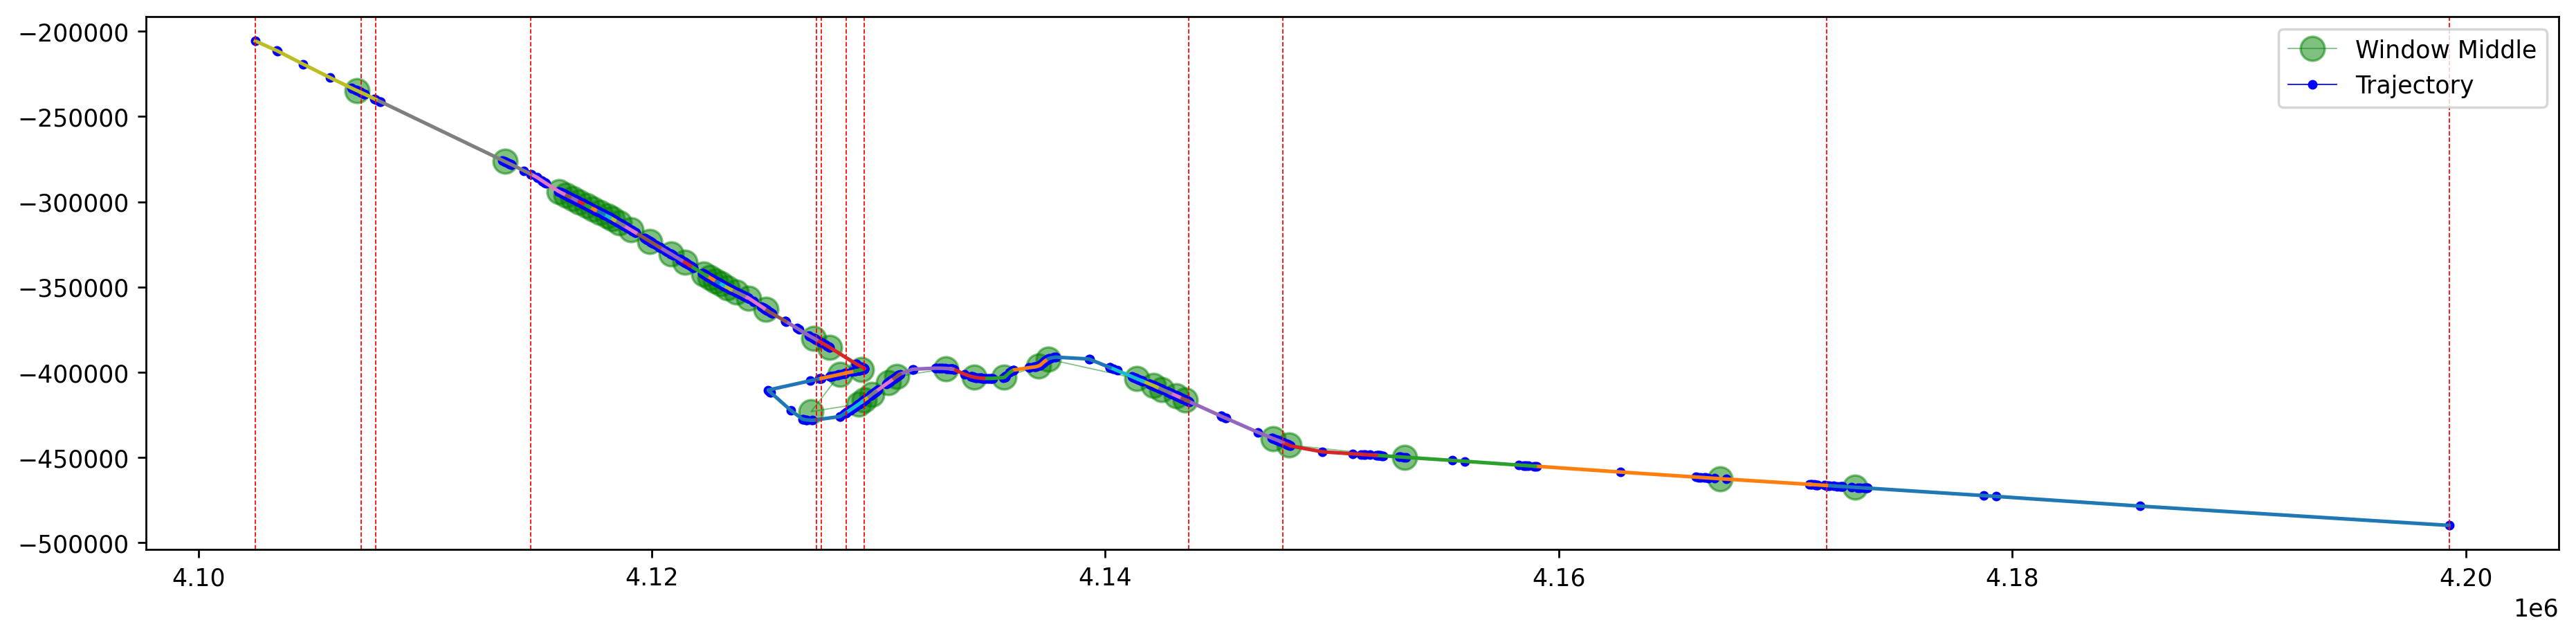

In [64]:
fig, ax = plt.subplots(figsize=(18, 4), dpi=250)

# plt.figure(figsize=(15,10), dpi=100)

ax.plot(
    middles[:,0],
    middles[:,1],
    marker='o',
    ms=10,
    linestyle='-',
    color='g',
    linewidth=0.5,
    alpha=0.5,
    label='Window Middle'
)

ax.plot(
    X[:,0],
    X[:,1],
    marker='o',
    ms=3,
    linestyle='-',
    color='b',
    linewidth=0.5,
    label='Trajectory'
)

for i, window in enumerate(windows):
    ax.plot(
        window[:, 0],
        window[:, 1],
        #label=f"Window {i+1}"
    )  # Plot each window

    # colour = "blue" if outlier_labels[i] == 1 else "red"
    # label = "Inlier" if outlier_labels[i] == 1 else "Outlier"

    if outlier_labels[i] == -1:
        # Add vertical lines at the start and end of outlier windows
        ax.axvline(x=window[0, 0], color="r", linestyle='--', linewidth=0.5)
        ax.axvline(x=window[-1, 0], color="r", linestyle='--', linewidth=0.5)

# Add a colorbar for the legend
plt.legend()

In [65]:
plt.close("all")

In [66]:
features[:2]

array([[1.96916053e+04, 1.96916053e+04, 1.96916053e+04, 1.96916053e+04,
        1.96916053e+04, 1.96916053e+04, 1.96916053e+04, 4.05283774e+02,
        4.05283774e+02, 4.05283774e+02, 0.00000000e+00, 1.90000000e+01],
       [3.66405843e+03, 3.66405843e+03, 3.66405843e+03, 3.66405843e+03,
        3.66405843e+03, 3.66405843e+03, 3.66405843e+03, 3.66405843e+03,
        3.66405843e+03, 9.09069017e+03, 9.00000000e+00, 1.00000000e+01]])

In [67]:
outlier_scores

array([4.80428426, 1.48659956, 1.48989114, 1.49709128, 3.12419217,
       1.12848327, 0.95488518, 0.99613136, 1.11305978, 1.21660571,
       1.36194193, 1.11644729, 1.28125845, 1.26947115, 1.36081811,
       1.05968721, 1.32858493, 0.96007988, 1.03187185, 1.30726008,
       2.50673922, 1.04530177, 1.07790033, 1.8636175 , 1.4866647 ,
       1.32220519, 1.46954985, 0.99190027, 1.21578842, 1.01753308,
       1.11327223, 0.96195761, 1.28276217, 0.9994158 , 1.45223067,
       1.19688841, 0.97019011, 0.95076386, 1.11746765, 0.96307067,
       0.98738142, 0.99018177, 0.98677487, 0.95062749, 0.99489806,
       0.95667595, 1.3379529 , 6.32881997, 3.54246793])

In [68]:
outlier_labels

array([-1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1])

In [69]:
len(windows)

49

## Improvements

1.   Parallelizing window processing since windows are independent
2.   Using vectorized operations for angle and distance calculations
3.   Pre-computing commonly used values like distances to middle point




In [57]:
np.median(np.array([[2,3], [4,5]]), axis=0)

array([3., 4.])

In [58]:
np.mean(np.array([[2,3], [4,5]]), axis=0)

array([3., 4.])